In [1]:
# Cell 1: Import Libraries

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score, precision_score, 
                             recall_score, f1_score)

import cv2  # OpenCV for hair removal, CLAHE, and naive segmentation
from PIL import Image



In [2]:
# Define 'device' (e.g., in Cell 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using Device:", device)


✅ Using Device: cuda


In [3]:
 # Cell 2: Hair Removal

def remove_hair_opencv(img_pil):
    """
    Removes hair from a PIL RGB image using morphological blackhat + inpainting.
    Steps:
      1) Convert PIL -> OpenCV (BGR)
      2) Gray -> Blackhat -> Threshold => hair mask
      3) Inpaint
      4) Return PIL (RGB)
    """
    img_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    dst = cv2.inpaint(img_bgr, mask, 1, cv2.INPAINT_TELEA)
    
    dst_rgb = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    return Image.fromarray(dst_rgb)


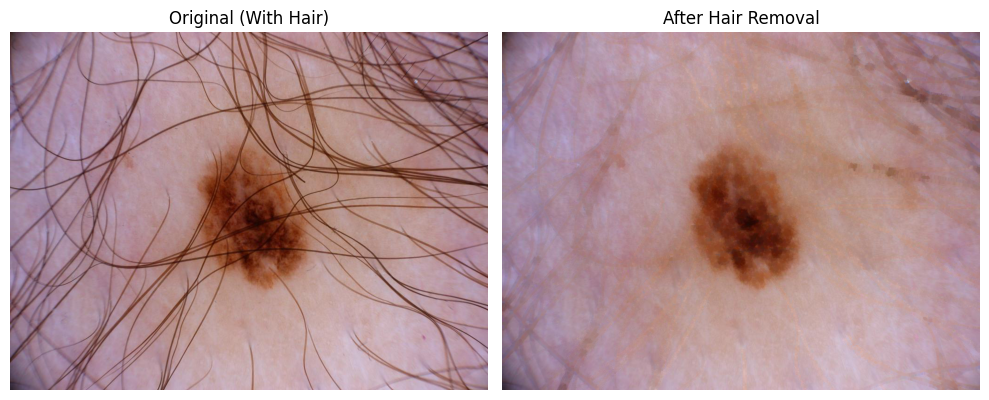

In [4]:
# Cell 3: Demonstration - Hair Removal

# Example image path
sample_image_path_hr = "/kaggle/input/skin-disease-dataset/Skin_Diseases_Dataset2/train/Melanocytic nevus/ISIC_0000095_downsampled.jpg"
original_img_hr = Image.open(sample_image_path_hr).convert('RGB')

hair_removed_img_hr = remove_hair_opencv(original_img_hr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img_hr)
plt.title("Original (With Hair)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hair_removed_img_hr)
plt.title("After Hair Removal")
plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
# Cell 4: CLAHE

def apply_clahe(img_pil):
    """
    Applies CLAHE (Contrast Limited Adaptive Histogram Equalization)
    to enhance local contrast in a PIL RGB image.
    Steps:
      1) PIL -> OpenCV (BGR)
      2) Convert BGR -> Lab
      3) CLAHE on L-channel
      4) Convert back to PIL (RGB)
    """
    img_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    lab_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    
    l, a, b = cv2.split(lab_img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    
    merged_lab = cv2.merge((l_clahe, a, b))
    clahe_bgr = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2BGR)
    clahe_rgb = cv2.cvtColor(clahe_bgr, cv2.COLOR_BGR2RGB)
    
    return Image.fromarray(clahe_rgb)


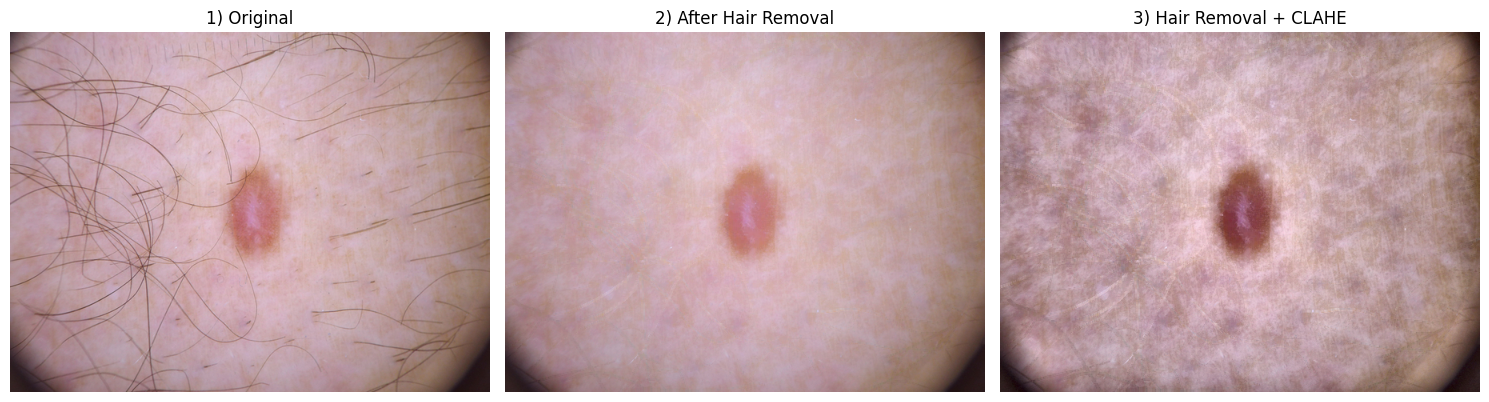

In [6]:
# Cell 5: Demonstration - Hair Removal + CLAHE

sample_image_path_hc = "/kaggle/input/skin-disease-dataset/Skin_Diseases_Dataset2/train/Dermatofibroma/ISIC_0031123.jpg"
original_img_hc = Image.open(sample_image_path_hc).convert('RGB')

# 1) Hair Removal
hr_img_hc = remove_hair_opencv(original_img_hc)

# 2) CLAHE
hr_clahe_img_hc = apply_clahe(hr_img_hc)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_img_hc)
plt.title("1) Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(hr_img_hc)
plt.title("2) After Hair Removal")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(hr_clahe_img_hc)
plt.title("3) Hair Removal + CLAHE")
plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
# Cell 6: Custom Transform (Hair Removal -> CLAHE -> Optional Erasing)

class HairRemovalCLAHETransform:
    """
    1) Hair Removal
    2) CLAHE
    3) (Optional) Random Erasing or other augmentations
    4) Convert to Tensor
    """
    def __init__(self, apply_erasing=False):
        self.apply_erasing = apply_erasing
        if self.apply_erasing:
            self.random_erase = transforms.RandomErasing(
                p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0
            )
        else:
            self.random_erase = None
    
    def __call__(self, img_pil):
        # 1) Hair Removal
        hr_img = remove_hair_opencv(img_pil)
        
        # 2) CLAHE
        clahe_img = apply_clahe(hr_img)
        
        # 3) Convert to Tensor
        tensor_img = transforms.ToTensor()(clahe_img)
        
        # Optional: Random Erasing
        if self.random_erase:
            tensor_img = self.random_erase(tensor_img)
        
        return tensor_img


In [8]:
# Cell 7: Data Transforms

train_transforms = transforms.Compose([
    HairRemovalCLAHETransform(apply_erasing=True),  # hair removal + CLAHE + erasing
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, 
                           contrast=0.2, 
                           saturation=0.2, 
                           hue=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    HairRemovalCLAHETransform(apply_erasing=False),  # hair removal + CLAHE only
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


In [9]:
# Cell 8: Load Dataset

train_dir = '/kaggle/input/skin-disease-dataset/Skin_Diseases_Dataset2/train'
test_dir = '/kaggle/input/skin-disease-dataset/Skin_Diseases_Dataset2/val'

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

print("Classes:", train_dataset.classes)
print("Number of training images:", len(train_dataset))
print("Number of validation images:", len(test_dataset))


Classes: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']
Number of training images: 697
Number of validation images: 181


In [10]:
# Cell 9: Class Weights & Sampler

class_counts = [0] * len(train_dataset.classes)
for _, lbl in train_dataset:
    class_counts[lbl] += 1

class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[lbl] for _, lbl in train_dataset]

sampler = WeightedRandomSampler(
    weights=sample_weights, 
    num_samples=len(sample_weights), 
    replacement=True
)

print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: [80, 81, 80, 80, 80, 80, 80, 56, 80]
Class Weights: tensor([0.0125, 0.0123, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0179, 0.0125])


In [11]:
# Cell 10: DataLoaders

batch_size = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=sampler, 
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)


In [12]:
# Cell 11: ResNet18 Modifications

resnet18_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze early layers if desired
for name, param in resnet18_model.named_parameters():
    if "layer1" in name or "layer2" in name:
        param.requires_grad = False

# Modify final FC for (e.g.) 9 classes
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 9)
)

resnet18_model = resnet18_model.to(device)
print("✅ Modified ResNet18:\n", resnet18_model)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


✅ Modified ResNet18:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu):

In [13]:
# Cell 12: Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    resnet18_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

print("🚀 Using a constant LR = 1e-4 (no scheduler).")


🚀 Using a constant LR = 1e-4 (no scheduler).


In [14]:
# Cell 13: Training Loop

num_epochs = 50
best_val_acc = 0.0
best_model = copy.deepcopy(resnet18_model.state_dict())

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("🚀 Starting ResNet18 Training (Hair Removal + CLAHE)...")

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training Phase
    resnet18_model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet18_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100.0 * correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation Phase
    resnet18_model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    epoch_val_loss = val_running_loss / len(test_loader)
    epoch_val_acc = 100.0 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_acc:.2f}% | Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_val_acc:.2f}% | Time: {epoch_time:.2f}s")
    
    # Track best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_model = copy.deepcopy(resnet18_model.state_dict())

resnet18_model.load_state_dict(best_model)
print(f"\n✅ Training complete! Best Validation Accuracy: {best_val_acc:.2f}%")


🚀 Starting ResNet18 Training (Hair Removal + CLAHE)...


Epoch 1/50: 100%|██████████| 44/44 [00:49<00:00,  1.13s/it]


Epoch [1/50] | Train Loss: 1.7957 | Train Acc: 37.88% | Val Loss: 1.0293 | Val Acc: 68.51% | Time: 61.11s


Epoch 2/50: 100%|██████████| 44/44 [00:49<00:00,  1.13s/it]


Epoch [2/50] | Train Loss: 1.1128 | Train Acc: 57.68% | Val Loss: 0.6830 | Val Acc: 75.69% | Time: 60.42s


Epoch 3/50: 100%|██████████| 44/44 [00:50<00:00,  1.15s/it]


Epoch [3/50] | Train Loss: 0.7981 | Train Acc: 70.30% | Val Loss: 0.5967 | Val Acc: 78.45% | Time: 61.24s


Epoch 4/50: 100%|██████████| 44/44 [00:50<00:00,  1.16s/it]


Epoch [4/50] | Train Loss: 0.6278 | Train Acc: 78.62% | Val Loss: 0.5621 | Val Acc: 76.24% | Time: 61.70s


Epoch 5/50: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it]


Epoch [5/50] | Train Loss: 0.5933 | Train Acc: 78.48% | Val Loss: 0.5071 | Val Acc: 79.01% | Time: 60.07s


Epoch 6/50: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it]


Epoch [6/50] | Train Loss: 0.5738 | Train Acc: 78.91% | Val Loss: 0.5350 | Val Acc: 80.66% | Time: 60.06s


Epoch 7/50: 100%|██████████| 44/44 [00:51<00:00,  1.17s/it]


Epoch [7/50] | Train Loss: 0.5470 | Train Acc: 81.64% | Val Loss: 0.4935 | Val Acc: 82.32% | Time: 62.64s


Epoch 8/50: 100%|██████████| 44/44 [00:50<00:00,  1.14s/it]


Epoch [8/50] | Train Loss: 0.4919 | Train Acc: 82.93% | Val Loss: 0.4773 | Val Acc: 84.53% | Time: 61.63s


Epoch 9/50: 100%|██████████| 44/44 [00:50<00:00,  1.14s/it]


Epoch [9/50] | Train Loss: 0.4622 | Train Acc: 83.93% | Val Loss: 0.4653 | Val Acc: 82.32% | Time: 60.54s


Epoch 10/50: 100%|██████████| 44/44 [00:51<00:00,  1.16s/it]


Epoch [10/50] | Train Loss: 0.4184 | Train Acc: 85.37% | Val Loss: 0.4590 | Val Acc: 82.32% | Time: 61.91s


Epoch 11/50: 100%|██████████| 44/44 [00:50<00:00,  1.14s/it]


Epoch [11/50] | Train Loss: 0.3850 | Train Acc: 86.80% | Val Loss: 0.4536 | Val Acc: 80.11% | Time: 61.38s


Epoch 12/50: 100%|██████████| 44/44 [00:50<00:00,  1.15s/it]


Epoch [12/50] | Train Loss: 0.3502 | Train Acc: 87.66% | Val Loss: 0.4684 | Val Acc: 80.66% | Time: 61.95s


Epoch 13/50: 100%|██████████| 44/44 [00:49<00:00,  1.14s/it]


Epoch [13/50] | Train Loss: 0.3959 | Train Acc: 85.22% | Val Loss: 0.5424 | Val Acc: 79.01% | Time: 60.91s


Epoch 14/50: 100%|██████████| 44/44 [00:53<00:00,  1.22s/it]


Epoch [14/50] | Train Loss: 0.2983 | Train Acc: 90.10% | Val Loss: 0.3798 | Val Acc: 85.08% | Time: 64.77s


Epoch 15/50: 100%|██████████| 44/44 [00:53<00:00,  1.21s/it]


Epoch [15/50] | Train Loss: 0.3071 | Train Acc: 89.67% | Val Loss: 0.4085 | Val Acc: 84.53% | Time: 64.60s


Epoch 16/50: 100%|██████████| 44/44 [00:50<00:00,  1.16s/it]


Epoch [16/50] | Train Loss: 0.3136 | Train Acc: 88.24% | Val Loss: 0.4015 | Val Acc: 86.19% | Time: 62.20s


Epoch 17/50: 100%|██████████| 44/44 [00:50<00:00,  1.16s/it]


Epoch [17/50] | Train Loss: 0.3125 | Train Acc: 88.67% | Val Loss: 0.4579 | Val Acc: 81.77% | Time: 62.22s


Epoch 18/50: 100%|██████████| 44/44 [00:49<00:00,  1.13s/it]


Epoch [18/50] | Train Loss: 0.2814 | Train Acc: 90.10% | Val Loss: 0.5528 | Val Acc: 81.22% | Time: 60.51s


Epoch 19/50: 100%|██████████| 44/44 [00:49<00:00,  1.13s/it]


Epoch [19/50] | Train Loss: 0.2568 | Train Acc: 91.82% | Val Loss: 0.5310 | Val Acc: 81.77% | Time: 61.20s


Epoch 20/50: 100%|██████████| 44/44 [00:52<00:00,  1.19s/it]


Epoch [20/50] | Train Loss: 0.2465 | Train Acc: 91.25% | Val Loss: 0.6234 | Val Acc: 80.66% | Time: 63.72s


Epoch 21/50: 100%|██████████| 44/44 [00:50<00:00,  1.14s/it]


Epoch [21/50] | Train Loss: 0.2055 | Train Acc: 93.26% | Val Loss: 0.4926 | Val Acc: 81.22% | Time: 61.80s


Epoch 22/50: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it]


Epoch [22/50] | Train Loss: 0.1909 | Train Acc: 93.54% | Val Loss: 0.5115 | Val Acc: 85.64% | Time: 61.78s


Epoch 23/50: 100%|██████████| 44/44 [00:51<00:00,  1.18s/it]


Epoch [23/50] | Train Loss: 0.2216 | Train Acc: 92.54% | Val Loss: 0.5579 | Val Acc: 83.43% | Time: 62.89s


Epoch 24/50: 100%|██████████| 44/44 [00:50<00:00,  1.14s/it]


Epoch [24/50] | Train Loss: 0.2036 | Train Acc: 92.54% | Val Loss: 0.5099 | Val Acc: 83.98% | Time: 61.70s


Epoch 25/50: 100%|██████████| 44/44 [00:50<00:00,  1.15s/it]


Epoch [25/50] | Train Loss: 0.1983 | Train Acc: 93.11% | Val Loss: 0.5149 | Val Acc: 83.43% | Time: 61.23s


Epoch 26/50: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it]


Epoch [26/50] | Train Loss: 0.1773 | Train Acc: 94.12% | Val Loss: 0.5308 | Val Acc: 83.98% | Time: 59.50s


Epoch 27/50: 100%|██████████| 44/44 [00:50<00:00,  1.14s/it]


Epoch [27/50] | Train Loss: 0.1971 | Train Acc: 93.40% | Val Loss: 0.5596 | Val Acc: 85.08% | Time: 60.83s


Epoch 28/50: 100%|██████████| 44/44 [00:52<00:00,  1.18s/it]


Epoch [28/50] | Train Loss: 0.1527 | Train Acc: 95.70% | Val Loss: 0.5807 | Val Acc: 81.77% | Time: 62.73s


Epoch 29/50: 100%|██████████| 44/44 [00:50<00:00,  1.15s/it]


Epoch [29/50] | Train Loss: 0.1946 | Train Acc: 94.12% | Val Loss: 0.4898 | Val Acc: 85.64% | Time: 61.43s


Epoch 30/50: 100%|██████████| 44/44 [00:49<00:00,  1.14s/it]


Epoch [30/50] | Train Loss: 0.1650 | Train Acc: 94.98% | Val Loss: 0.6666 | Val Acc: 81.22% | Time: 60.51s


Epoch 31/50: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it]


Epoch [31/50] | Train Loss: 0.1347 | Train Acc: 95.98% | Val Loss: 0.4787 | Val Acc: 83.98% | Time: 59.11s


Epoch 32/50: 100%|██████████| 44/44 [00:49<00:00,  1.13s/it]


Epoch [32/50] | Train Loss: 0.1485 | Train Acc: 95.55% | Val Loss: 0.5288 | Val Acc: 81.22% | Time: 60.46s


Epoch 33/50: 100%|██████████| 44/44 [00:50<00:00,  1.15s/it]


Epoch [33/50] | Train Loss: 0.1452 | Train Acc: 95.41% | Val Loss: 0.4543 | Val Acc: 84.53% | Time: 62.02s


Epoch 34/50: 100%|██████████| 44/44 [00:49<00:00,  1.13s/it]


Epoch [34/50] | Train Loss: 0.1550 | Train Acc: 94.98% | Val Loss: 0.5502 | Val Acc: 85.08% | Time: 60.88s


Epoch 35/50: 100%|██████████| 44/44 [00:52<00:00,  1.18s/it]


Epoch [35/50] | Train Loss: 0.1381 | Train Acc: 95.41% | Val Loss: 0.4994 | Val Acc: 82.32% | Time: 63.64s


Epoch 36/50: 100%|██████████| 44/44 [00:52<00:00,  1.20s/it]


Epoch [36/50] | Train Loss: 0.1417 | Train Acc: 95.55% | Val Loss: 0.4692 | Val Acc: 85.64% | Time: 64.12s


Epoch 37/50: 100%|██████████| 44/44 [00:49<00:00,  1.14s/it]


Epoch [37/50] | Train Loss: 0.1716 | Train Acc: 94.69% | Val Loss: 0.4980 | Val Acc: 85.64% | Time: 61.48s


Epoch 38/50: 100%|██████████| 44/44 [00:51<00:00,  1.18s/it]


Epoch [38/50] | Train Loss: 0.1590 | Train Acc: 94.69% | Val Loss: 0.4896 | Val Acc: 84.53% | Time: 63.28s


Epoch 39/50: 100%|██████████| 44/44 [00:49<00:00,  1.14s/it]


Epoch [39/50] | Train Loss: 0.1573 | Train Acc: 94.55% | Val Loss: 0.5571 | Val Acc: 85.64% | Time: 61.12s


Epoch 40/50: 100%|██████████| 44/44 [00:51<00:00,  1.17s/it]


Epoch [40/50] | Train Loss: 0.1376 | Train Acc: 94.98% | Val Loss: 0.4645 | Val Acc: 87.29% | Time: 62.65s


Epoch 41/50: 100%|██████████| 44/44 [00:51<00:00,  1.17s/it]


Epoch [41/50] | Train Loss: 0.1242 | Train Acc: 96.41% | Val Loss: 0.4622 | Val Acc: 87.29% | Time: 62.91s


Epoch 42/50: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it]


Epoch [42/50] | Train Loss: 0.1236 | Train Acc: 95.98% | Val Loss: 0.4717 | Val Acc: 88.40% | Time: 59.28s


Epoch 43/50: 100%|██████████| 44/44 [00:49<00:00,  1.13s/it]


Epoch [43/50] | Train Loss: 0.1309 | Train Acc: 95.70% | Val Loss: 0.5792 | Val Acc: 82.87% | Time: 60.31s


Epoch 44/50: 100%|██████████| 44/44 [00:52<00:00,  1.20s/it]


Epoch [44/50] | Train Loss: 0.1326 | Train Acc: 95.41% | Val Loss: 0.4357 | Val Acc: 88.40% | Time: 63.50s


Epoch 45/50: 100%|██████████| 44/44 [00:50<00:00,  1.15s/it]


Epoch [45/50] | Train Loss: 0.1238 | Train Acc: 96.70% | Val Loss: 0.4887 | Val Acc: 87.85% | Time: 61.27s


Epoch 46/50: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it]


Epoch [46/50] | Train Loss: 0.1417 | Train Acc: 94.84% | Val Loss: 0.4578 | Val Acc: 87.85% | Time: 59.95s


Epoch 47/50: 100%|██████████| 44/44 [00:50<00:00,  1.14s/it]


Epoch [47/50] | Train Loss: 0.0973 | Train Acc: 96.84% | Val Loss: 0.4826 | Val Acc: 86.19% | Time: 61.10s


Epoch 48/50: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it]


Epoch [48/50] | Train Loss: 0.1083 | Train Acc: 96.56% | Val Loss: 0.5640 | Val Acc: 82.87% | Time: 59.14s


Epoch 49/50: 100%|██████████| 44/44 [00:52<00:00,  1.19s/it]


Epoch [49/50] | Train Loss: 0.1520 | Train Acc: 95.55% | Val Loss: 0.6923 | Val Acc: 83.98% | Time: 63.06s


Epoch 50/50: 100%|██████████| 44/44 [00:46<00:00,  1.06s/it]


Epoch [50/50] | Train Loss: 0.1445 | Train Acc: 94.40% | Val Loss: 0.6241 | Val Acc: 81.77% | Time: 57.47s

✅ Training complete! Best Validation Accuracy: 88.40%


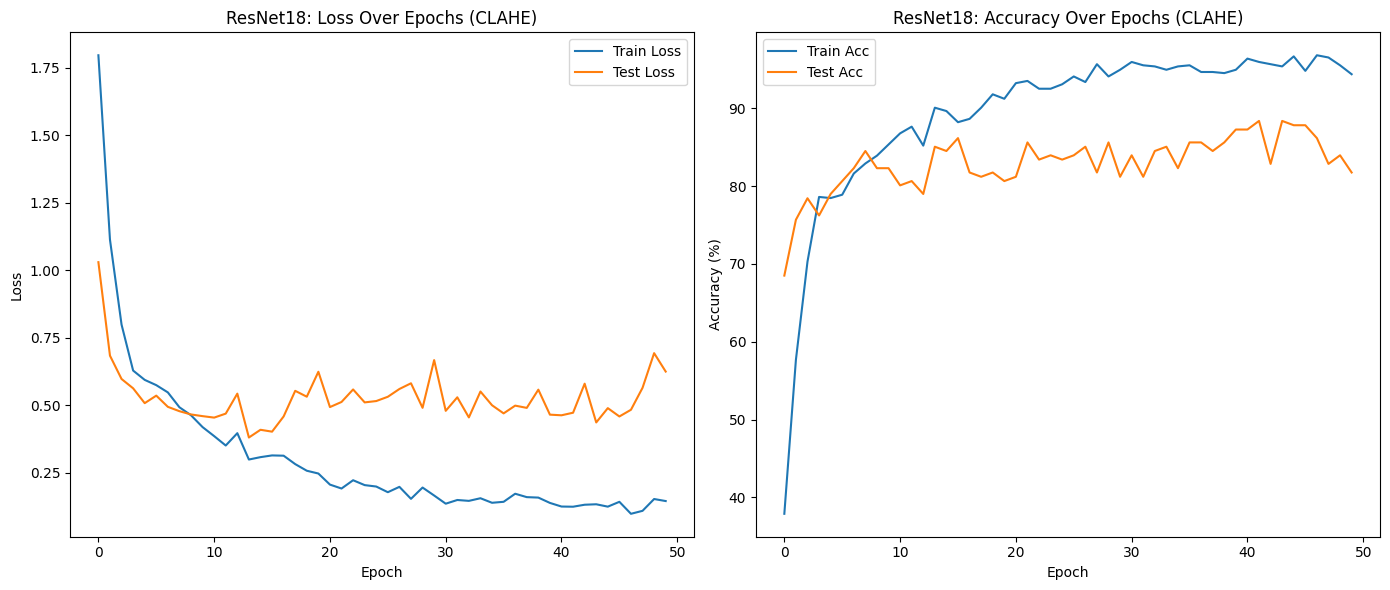

In [22]:
# Cell 14: Plotting Curves

plt.figure(figsize=(14, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.title('ResNet18: Loss Over Epochs (CLAHE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Test Acc')
plt.title('ResNet18: Accuracy Over Epochs (CLAHE)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


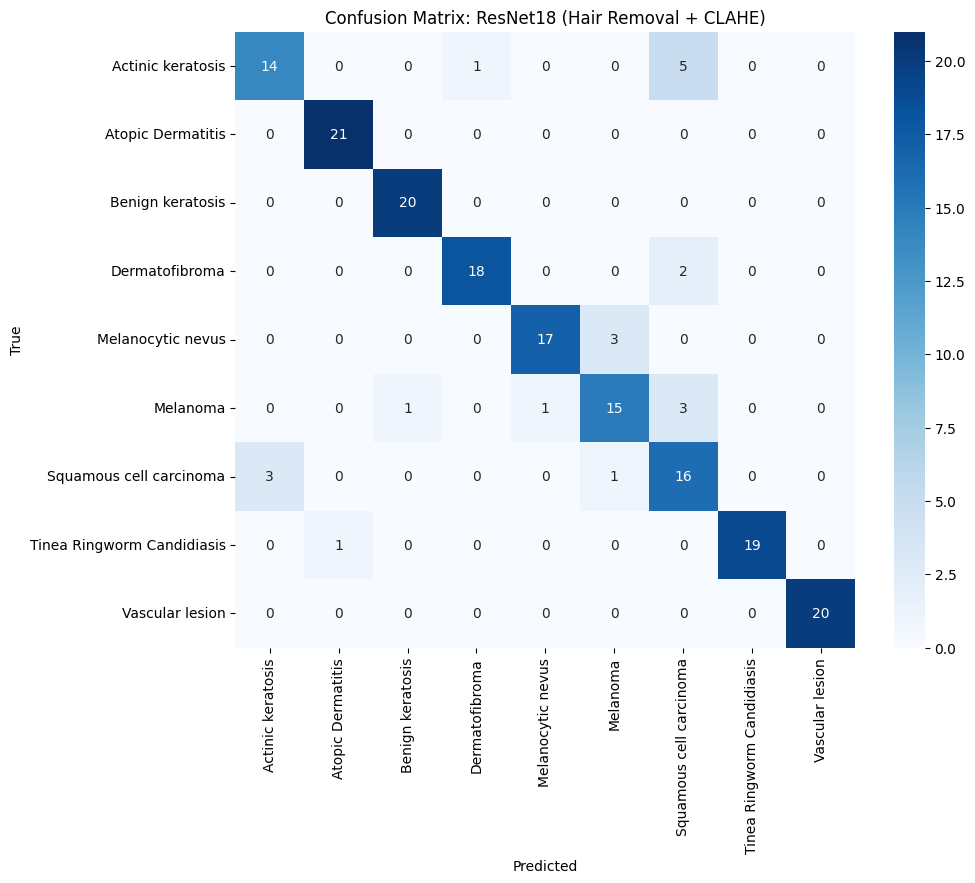


✅ Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.82      0.70      0.76        20
         Atopic Dermatitis       0.95      1.00      0.98        21
          Benign keratosis       0.95      1.00      0.98        20
            Dermatofibroma       0.95      0.90      0.92        20
         Melanocytic nevus       0.94      0.85      0.89        20
                  Melanoma       0.79      0.75      0.77        20
   Squamous cell carcinoma       0.62      0.80      0.70        20
Tinea Ringworm Candidiasis       1.00      0.95      0.97        20
           Vascular lesion       1.00      1.00      1.00        20

                  accuracy                           0.88       181
                 macro avg       0.89      0.88      0.89       181
              weighted avg       0.89      0.88      0.89       181


Overall Accuracy: 88.40%
Error Rate: 0.1160
Precision (Macro Avg): 0.8919
Recall (Macr

In [16]:
# Cell 15: Final Evaluation

resnet18_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title("Confusion Matrix: ResNet18 (Hair Removal + CLAHE)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("\n✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Additional Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
err = 1 - acc

print(f"\nOverall Accuracy: {acc*100:.2f}%")
print(f"Error Rate: {err:.4f}")
print(f"Precision (Macro Avg): {prec:.4f}")
print(f"Recall (Macro Avg): {rec:.4f}")
print(f"F1-Score (Macro Avg): {f1:.4f}")

def calculate_specificity_per_class(conf_mat):
    specificity_per_class = []
    num_classes = conf_mat.shape[0]
    for i in range(num_classes):
        TP = conf_mat[i, i]
        FP = np.sum(conf_mat[:, i]) - TP
        FN = np.sum(conf_mat[i, :]) - TP
        TN = np.sum(conf_mat) - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        specificity_per_class.append(specificity)
    return np.mean(specificity_per_class), specificity_per_class

spec_avg, spec_per_class = calculate_specificity_per_class(cm)
print(f"Specificity (Macro Avg): {spec_avg:.4f}")

print("\n✅ Specificity per Class:")
for i, spec in enumerate(spec_per_class):
    print(f"{train_dataset.classes[i]}: {spec:.4f}")


In [20]:
import torch

# Suppose 'model' is your evi-CEM or other PyTorch model instance
# 1) Save the model state_dict (recommended best practice)
model_save_path_state_dict = "/kaggle/working/evi_cem_state_dict.pth"
torch.save(resnet18_model.state_dict(), model_save_path_state_dict)
print(f"Model state_dict saved to: {model_save_path_state_dict}")

# 2) Save the entire model (less common, but sometimes used)
model_save_path_entire = "/kaggle/working/evi_cem_entire_model.pth"
torch.save(resnet18_model, model_save_path_entire)
print(f"Entire model object saved to: {model_save_path_entire}")


Model state_dict saved to: /kaggle/working/evi_cem_state_dict.pth
Entire model object saved to: /kaggle/working/evi_cem_entire_model.pth
